In [1]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.optimize import fmin
import pandas as pd
from math import hypot
from scipy.optimize import curve_fit

In [ ]:
# instructions, capabilities, assumptions, ect.

In [ ]:
# cite resources

In [ ]:
# optimization "Select Parameters with SSE Optimization": https://www.youtube.com/watch?v=qYdrLyY2bNk



In [ ]:
# using depth tolerance might be better because we can understand depth error (rather than mech eng head)

In [96]:
# enter length of channel and spatial step
dx = 1
l = 500
elev = 10 # datum at downstream
g = 9.81

In [ ]:
# enter upstream water level delivering flow to the canal through radial sluice gate
h1 = 5

# find parameters just d/s of gate



In [ ]:
# enter downstream sharp crested weir properties
# equations used:


In [120]:
# enter bed slope
s0 = 0.001
s1 = 0.0002
s2 = 0.0003

# enter locations of channel geometry change
# station 0 is at d/s end

xs0 = 100
xs1 = 350
xs2 = 450

station = np.arange(0,l,dx)

x = []

for i in station:
    if i == 0:
        x.append(elev)
    elif i <= xs0:
        x.append(x[i-1]+(dx*s0))
    elif i <= xs1:
        x.append(x[i-1]+(dx*s1))
    else:
        x.append(x[i-1]+(dx*s2))


In [ ]:
# enter cross sectional geometry
# start with prismatic channel
##w = 20
##h = 7

# enter locations of channel geometry change
##xgeo1 = 

# for regular cross section:
# gamma as a function of x, define piecewise function through loop

C:\Users\GSCOB\AppData\Local\Temp\ipykernel_12720\255142541.py:66: RuntimeWarning: invalid value encountered in double_scalars
  R = [i / j for i, j in zip(area, p)]


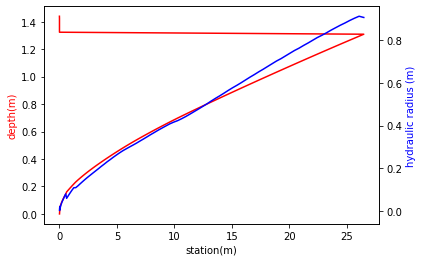

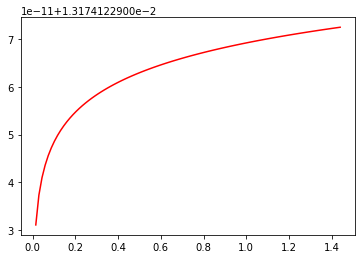

<function matplotlib.pyplot.show(close=None, block=None)>

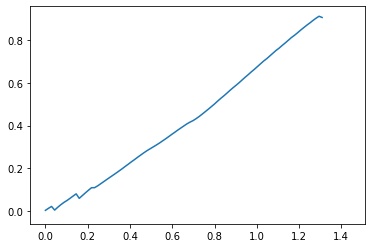

In [149]:
# for irregular cross section:
# import csv of surveys
fname1 = "xs1.csv" # define file name, must be in working directory
xs1 = pd.read_csv(fname1) # read into pandas dataframe
x = xs1['Station (m)'] # define x as station, depends on actual collumn name
y = xs1['Elev (m)'] # define y as elevation, depends on actual collumn name (execute xs1.columns for dataframe column names)

# read second cross section, iterate for multiple cross sections
##fname2 = "xs2.csv"
##xs2 = pd.read_csv(fname)

# calculate cross sectional area for several WSE
f2 = interp1d(x, y, kind='cubic') # use cubic interpolation to define continuous cross section function

xnew = np.linspace(min(x), max(x), num=1000, endpoint=True) # create index array for x
ynew = np.linspace(min(y), max(y), num=100, endpoint=True) # create index array for y
area = []
depth = []
p = []

# define function to calculate wetted perimeter
## https://stackoverflow.com/questions/46098157/how-to-calculate-the-length-of-a-curve-of-a-math-function
def arclength(f, a, b, tol=1e-6):
    nsteps = 1  # number of steps to compute
    oldlength = 1.0e20
    length = 1.0e10
    while abs(oldlength - length) >= tol:
        nsteps *= 2
        fx1 = f(a)
        xdel = (b - a) / nsteps  # space between x-values
        oldlength = length
        length = 0
        for i in range(1, nsteps + 1):
            fx0 = fx1  # previous function value
            fx1 = f(a + i * (b - a) / nsteps)  # new function value
            length += hypot(xdel, fx1 - fx0)  # length of small line segment
    return length

for i in ynew:
    y_0=[i for j in range(1000)] # create water surface array
    idx = np.argwhere(np.diff(np.sign(f2(xnew) - y_0))).flatten() # find intersection between water surface and cross section
    auc = integrate.quad(f2, (xnew[min(idx)]), (xnew[max(idx)])) # find area under xs curve
    rec = (max(xnew[idx])-min(xnew[idx]))*i # find area in rectangle 
    xsa = rec-auc[0] # subtract auc from rectangle to find area in cross section
    area.append(xsa)
    p.append(arclength(f2, (xnew[min(idx)]), (xnew[max(idx)]), 1e-3))

# find depth to lowest point or thalweg
#t = fmin(f2,1) # returns incorrect value, why??
t = min(y) # define thalweg elevation
t = [t for i in ynew]    
depth = ynew-t 

R = [i / j for i, j in zip(area, p)]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(area, depth,'r')
ax2.plot(area, R,'b')

ax1.set_xlabel('station(m)')
ax1.set_ylabel('depth(m)',color='r')
ax2.set_ylabel('hydraulic radius (m)',color='b')

plt.show()

# create power relationship between R and h
def func(x, m, c):
    return c*x**m

xdata = depth[depth!=0]
ydata = area[area!=0]

popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-')
#plt.plot(depth,area,'b-')
plt.show()

plt.plot(depth,R)
plt.show

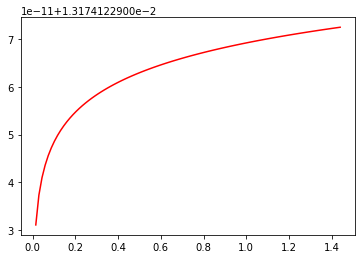

In [143]:
# create power relationship between R and h

def func(x, m, c):
    return c*x**m

xdata = depth[depth!=0]
ydata = area[area!=0]

popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-')

plt.show()

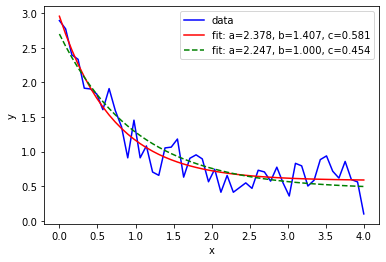

In [138]:
# example power fit, cite then DELETE

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

popt, pcov = curve_fit(func, xdata, ydata)

plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))

plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [90]:
# enter hydraulic resistance
# example with change in resistance
n0 = 0.03
n1 = 0.01

# enter locations of n change
xn1 = 50
xn2 = 350

n = []

for i in station:
    if i <=xn1:
        n.append(n0)
    elif i <=xn2:
        n.append(n1)
    else:
        n.append(n0)


In [92]:
# enter lateral inflow/outflow
# start with constant q
q0 = -0.5
q1 = 0
q2 = -0.001

# enter locations of q change
xq1 = 100
xq2 = 450

q = []

for i in station:
    if i <=xq1:
        q.append(q0)
    elif i <=xq2:
        q.append(q1)
    else:
        q.append(q2)

In [95]:
# enter kinetic energy correction factor
# start with alpha = 1
alpha0 = 1
alpha1 = 0.9

# enter location of alpha change
xalpha1 = 350

alpha = []

for i in station:
    if i <=xalpha1:
        alpha.append(alpha0)
    else:
        alpha.append(alpha1)
        

In [157]:
# enter contraction loss coefficients
cc1 = 0.5
cc2 = 0.4

# enter expansion loss coefficients
ce1 = 0.4
ce2 = 0.8

# enter location of contraction
xc1 = np.arange(50,70,dx)
xc2 = np.arange(300,350,dx)

# enter location of expansions
xe1 = np.arange(70,80,dx)
xe2 = np.arange(350,400,dx)

u = np.random.uniform(low=2,high=10,size=(l)) # test values
ustar = np.random.uniform(low=2,high=10,size=(l)) # test values

# define function for change in energy head caused by contraction/expansion
def sudden(c,alpha,ustar,u,g):
    return c*np.absolute(((alpha*ustar**2)/(2*g))-((alpha*u**2)/(2*g)))

# solve for spatially varying headloss caused by contractions and expansions

Hec = []

for i in station:
    if (i !=xc1).all() and (i !=xc2).all() and (i !=xe1).all() and (i !=xe2).all():
        Hec.append(0)
    elif (i==xc1).any():
        Hec.append(sudden(cc1,alpha[i],ustar[i],u[i],g))
    elif (i==xc2).any():
        Hec.append(sudden(cc2,alpha[i],ustar[i],u[i],g))
    elif (i==xe1).any():
        Hec.append(sudden(ce1,alpha[i],ustar[i],u[i],g))
    else:
        Hec.append(sudden(ce2,alpha[i],ustar[i],u[i],g))


In [151]:
# enter bend loss coefficients
cb1 = 0.055
cb2 = 0.058

# enter location of channel bends
xb1 = np.arange(50,70,dx)
xb2 = np.arange(400,420,dx)

u = np.random.uniform(low=2,high=10,size=(l)) # test values

# define function for change in energy head caused by bend
def bend(c,alpha,u,g):
    return c*(alpha*u**2)/(2*g)

# solve for spatially varying headloss caused by bend
Hb = []

for i in station:
    if (i !=xb1).all() and (i !=xb2).all():
        Hb.append(0)
    elif (i==xb1).any():
        Hb.append(bend(cb1,alpha[i],u[i],g))
    else:
        Hb.append(bend(cb2,alpha[i],u[i],g))
        

In [ ]:
# in-stream regulating structure located mid length (broad crested weir or vertical sluice gate)
# define parameters of structure


# define location of structure
x = X/2

In [ ]:
# radial sluice off-take structures

# define locations of gates upstream of regulating structure
xgate1 = 
xgate2 = 
xgate3 = 

# define locations of gates downstream of regulating structure
xgate4 = 
xgate5 = 

In [ ]:
# calculate flow rate
# equations used:

# create plot that shows flow rate as a function of position, if result merges on accurate solution




In [ ]:
# calculate cross sectional averaged velocity
# equations used:


# plot over x

In [ ]:
# calculate flow depth

# equations used:


# plot over x

In [ ]:
# calculate water surface elevation
# equations used:

# plot over x


In [ ]:
# calculate Froude number
# equations used:


# plot over x


In [ ]:
# calculate total mechanical energy head
# equations used:


# plot over x


In [ ]:
# calculate off-take flow rates
# equations used:


# plot over x
